In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import json
import subprocess
import datetime

from pathlib import Path
from scipy.io import loadmat, savemat

In [2]:
import numpy as np
from scipy.optimize import least_squares


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]



def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')



def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))



def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    # Define additional functions required for optimization here
    # e.g., polynomial_form(x), representation_learning_obj(x), etc.
    
    U, _, _ = np.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    
    # Initialize Shat and other variables
    if initial_Shat:
        Shat = initial_Shat
    
    else:
        Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))
    
    for niter in range(max_iter):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = np.linalg.svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.identity((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        for snapshot in range(num_snapshots):
            
            # Shat[:, snapshot] = least_squares(lambda x: representation_learning_obj(x, snapshot, Vr, Vbar, Xi, S, sref, p=p), Shat[:, snapshot], ftol=1e-9).x
            Shat[:, snapshot] = least_squares(representation_learning_obj, Shat[:, snapshot], args=(snapshot, Vr, Vbar, Xi, S, sref, p), ftol=1e-9).x
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
# Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, initial_Shat, gamma, r, q, p)


In [20]:
import subprocess

# Define your MATLAB function's arguments
N = 2**7 + 1  # Example value; adjust as needed
dt = 1e-4  # Example value; adjust as needed
T_end = 1  # Example value; adjust as needed
# mus = "0.01:0.01:0.1"  # MATLAB array syntax
Mp = 10
K = T_end / dt
DS = 1

p = 3

In [21]:
# define perturbations to the nominal parameter mu=0.01. Perturbations of +-0.001% and +-0.01% are considered.
nominal_mu = 0.01
# perturbations in percentage
perturbations = [0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
# perturbations = [0.0001, 0.0005]
mus = [nominal_mu * (1 + pert) for pert in perturbations] + [nominal_mu * (1 - pert) for pert in perturbations]
print(mus)


[0.01001, 0.01002, 0.010029999999999999, 0.01004, 0.01005, 0.0101, 0.0102, 0.0103, 0.010400000000000001, 0.0105, 0.00999, 0.009980000000000001, 0.00997, 0.00996, 0.00995, 0.0099, 0.0098, 0.0097, 0.0096, 0.0095]


In [24]:
import json

datapath = '/data1/jy384/research/Data/UnimodalSROB/Burgers/'
srcpath = '/home/jy384/projects/UnimodalSROB/examples/burgers/'


# generate number UID based on perturbations, by creating a number based on the perturbations
scaling = 1e-6
uid = str('_'.join([str(int(pert * 1/scaling)) for pert in perturbations]))

config = {
    "N": 2**7 + 1,
    "dt": 1e-4,
    "T_end": 1,
    "mus": mus,
    "nominal_mu": int(nominal_mu*1/scaling),
    "Mp": 10,
    "K": 1 / 1e-4,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQIPC",
        "modeltime": "continuous",
        "dt": 1e-4,
        "ddt_order": "4ex",
        "p": p, # polynomial order
        "lambda1": 0.5,
        "lambda2": 0.5,
        "lambda3": 160.5,
    },
    "perturbations": perturbations,
    "uid": uid,
    "uid_naming_scale": scaling,
    
}

# unique config file for each perturbation experiment 
config_path = Path(srcpath) / 'configs'/ f'config_nominalmu_{int(nominal_mu*1/scaling)}_perturb_{uid}.json'

with open(config_path, 'w') as f:
    json.dump(config, f)


In [25]:
# Proper command to call your MATLAB function
matlab_cmd = (
    f"matlab -batch \"addpath('/home/jy384/projects/UnimodalSROB/examples/burgers/burgers-helpers'); "
    f"runburgers({N}, {dt}, {T_end}, [{mus}], {Mp}, {DS}, '{config_path}'); exit;\""
)

# Use subprocess to call MATLAB
subprocess.run(matlab_cmd, shell=True, check=True)

MATLAB is selecting SOFTWARE OPENGL rendering.
Running Burgers equation data generation
Parameters:
N = 129
dt = 0.0001
T_end = 1
mus = 0.01001     0.01002     0.01003     0.01004     0.01005      0.0101      0.0102      0.0103      0.0104      0.0105     0.00999     0.00998     0.00997     0.00996     0.00995      0.0099      0.0098      0.0097      0.0096      0.0095
Mp = 10
DS = 1
mu = 0.01001
mu = 0.01002
mu = 0.01003
mu = 0.01004
mu = 0.01005
mu = 0.0101
mu = 0.0102
mu = 0.0103
mu = 0.0104
mu = 0.0105
mu = 0.00999
mu = 0.00998
mu = 0.00997
mu = 0.00996
mu = 0.00995
mu = 0.0099
mu = 0.0098
mu = 0.0097
mu = 0.0096
mu = 0.0095
       99960          20



CompletedProcess(args='matlab -batch "addpath(\'/home/jy384/projects/UnimodalSROB/examples/burgers/burgers-helpers\'); runburgers(129, 0.0001, 1, [[0.01001, 0.01002, 0.010029999999999999, 0.01004, 0.01005, 0.0101, 0.0102, 0.0103, 0.010400000000000001, 0.0105, 0.00999, 0.009980000000000001, 0.00997, 0.00996, 0.00995, 0.0099, 0.0098, 0.0097, 0.0096, 0.0095]], 10, 1, \'/home/jy384/projects/UnimodalSROB/examples/burgers/configs/config_nominalmu_10000_perturb_1000_2000_3000_4000_5000_10000_20000_30000_40000_50000.json\'); exit;"', returncode=0)

In [7]:
mu_start = mus[0]
mu_end = mus[-1]
mu_step = mus[1] - mus[0]

print(mu_start, mu_end, mu_step)

0.01001 0.0095 9.999999999999593e-06


In [8]:
mu_step

9.999999999999593e-06

In [26]:
# check and load data
mu_start = mus[0]
mu_end = mus[-1]
mu_step = mus[1] - mus[0]

trajectories_path = Path(datapath) / 'trajectories'
snapshots_path = Path(datapath) / 'snapshots'
snapshotsDerivatives_path = Path(datapath) / 'snapshotsDerivatives'


if not perturbations:
    
    print("No Perturbations")
    
    # Find the files 
    U_all_files = list(Path(datapath).rglob(f'U_all_mu_*'))
    X_all_files = list(Path(datapath).rglob(f'X_all_mu_*'))
    R_all_files = list(Path(datapath).rglob(f'R_all_mu_*'))

    # Load the data with the mu_start, mu_end, and mu_step in their names
    if U_all_files:
        for file in U_all_files:
            if str(mu_start) in file.name and str(mu_end) in file.name and str(mu_step) in file.name:
                print(file)
                U_all = loadmat(file)['U_all']
    if X_all_files:
        for file in X_all_files:
            if str(mu_start) in file.name and str(mu_end) in file.name and str(mu_step) in file.name:
                print(file)
                X_all = loadmat(file)['X_all']
    if R_all_files:
        for file in R_all_files:
            if str(mu_start) in file.name and str(mu_end) in file.name and str(mu_step) in file.name:
                print(file)
                R_all = loadmat(file)['R_all']
            
else:
    
    print('Files for Perturbations:', perturbations)
    
    # Find the files
    U_all_files = list(Path(datapath).rglob(f'U_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb*'))
    X_all_files = list(Path(datapath).rglob(f'X_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb*'))
    R_all_files = list(Path(datapath).rglob(f'R_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb*'))
    
    # Load the data without the mu_start, mu_end, and mu_step in their names
    if U_all_files:
        for file in U_all_files:
            if str(uid) in file.name:
                print(file)
                U_all = loadmat(file)['U_all']
    if X_all_files:
        for file in X_all_files:
            if str(uid) in file.name:
                print(file)
                X_all = loadmat(file)['X_all']
    if R_all_files:
        for file in R_all_files:
            if str(uid) in file.name:
                print(file)
                R_all = loadmat(file)['R_all']

Files for Perturbations: [0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
/data1/jy384/research/Data/UnimodalSROB/Burgers/trajectories/U_all_nominalmu_10000_perturb_1000_2000_3000_4000_5000_10000_20000_30000_40000_50000.mat
/data1/jy384/research/Data/UnimodalSROB/Burgers/snapshots/X_all_nominalmu_10000_perturb_1000_2000_3000_4000_5000_10000_20000_30000_40000_50000.mat
/data1/jy384/research/Data/UnimodalSROB/Burgers/snapshotsDerivatives/R_all_nominalmu_10000_perturb_1000_2000_3000_4000_5000_10000_20000_30000_40000_50000.mat


In [27]:
# Convert cell arrays to numpy arrays for X_all and R_all
X_all = np.array([X_all[0][i] for i in range(X_all.shape[1])])
R_all = np.array([R_all[0][i] for i in range(R_all.shape[1])])

print(U_all.shape, X_all.shape, R_all.shape)

(99960, 20) (20, 129, 99960) (20, 129, 99960)


# SVD of X to get ROB 

S =  [863.73465286 231.97443469 104.16503661  66.72684696  39.19929342]
idx =  9
rel_err_SVD[idx] =  8.724354207956253e-07
S =  [863.81802389 231.00400399 104.19697204  66.84450765  39.01670004]
idx =  9
rel_err_SVD[idx] =  8.683970249556694e-07
S =  [865.67166102 233.84733773 104.94216585  66.92736115  39.18970792]
idx =  9
rel_err_SVD[idx] =  9.051897000844633e-07
S =  [861.91853368 230.53771016 103.4129937   66.50772148  38.85336653]
idx =  9
rel_err_SVD[idx] =  8.625472547318935e-07
S =  [865.02000064 231.35464761 103.72594631  66.65884073  38.94416529]
idx =  9
rel_err_SVD[idx] =  8.594699369979253e-07
S =  [866.20972152 231.56210983 103.98169323  66.8960743   39.00294674]
idx =  9
rel_err_SVD[idx] =  8.523623233891442e-07
S =  [865.81457798 229.78493971 102.94733114  66.26885354  38.40070912]
idx =  9
rel_err_SVD[idx] =  7.982188564570336e-07
S =  [866.50258388 231.11509479 103.63513858  66.56844961  38.77611721]
idx =  9
rel_err_SVD[idx] =  8.153386653608763e-07
S =  [865.244282

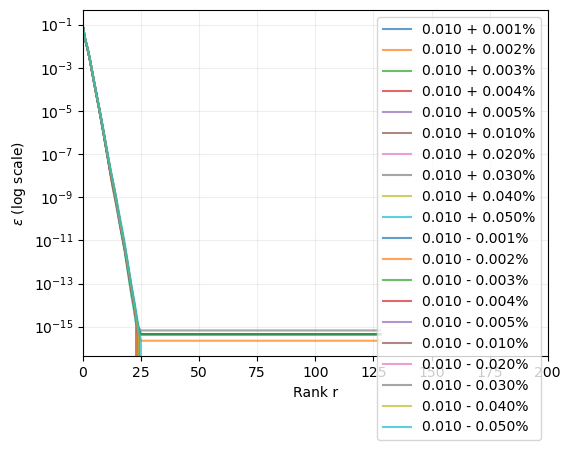

In [28]:
rob_lst = []
rel_err_SVD_lst = []
idx_lst = []

# determine float precision for mus so that it can be used as labels
precision = np.log10(1/np.min(perturbations))
# names is for each perturbation, plus then minus, 
# for example: nominal_mu=0.01, perturbations=[0.001, 0.01], then names = ['0.01 + 0.001%', '0.01 + 0.01%', '0.01 - 0.001%', '0.01 - 0.01%']
names = [f'{mu:.{int(precision)}f} + {pert:.{int(precision)}f}%' for mu in [nominal_mu] for pert in perturbations] + [f'{mu:.{int(precision)}f} - {pert:.{int(precision)}f}%' for mu in [nominal_mu] for pert in perturbations]

fig, ax = plt.subplots(figsize=(6, 4.5))


for i in range(len(mus)):
    # svd
    U, S, V = np.linalg.svd(X_all[i, :, :], full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (K*Mp-1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD <= 1e-6)[0][0]
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.legend()

In [29]:
proj_error_lst = []

for r in range(20):
    proj_error = (1/len(mus)) * np.sum([(np.linalg.norm(X_all[i, :, :] - rob_lst[i][:, :r] @ rob_lst[i][:, :r].T @ X_all[i, :, :], ord='fro')**2)/np.linalg.norm(X_all[i, :, :], ord='fro')**2 for i in range(len(mus))])
    # proj_error = (1/len(mus)) * np.sum([(np.linalg.norm(X_all[i, :, :] - X_all[i, :, :].T @ rob_lst[i][:, r] @ rob_lst[i][:, r].T, ord='fro')**2)/np.linalg.norm(X_all[i, :, :], ord='fro')**2 for i in range(len(mus))])
    print("proj_error = ", proj_error)
    proj_error_lst.append(proj_error)
        

proj_error =  1.0
proj_error =  0.0868126040565776
proj_error =  0.021231336672466208
proj_error =  0.007978367913299044
proj_error =  0.002519826429102979
proj_error =  0.0006521673397654516
proj_error =  0.0001753280350642266
proj_error =  4.909483288037547e-05
proj_error =  1.3540518027572262e-05
proj_error =  3.552903250246923e-06
proj_error =  8.877015376130142e-07
proj_error =  2.1453992263560743e-07
proj_error =  5.1643156114285124e-08
proj_error =  1.3237106500349999e-08
proj_error =  3.838362851229762e-09
proj_error =  1.0994338012185888e-09
proj_error =  2.743054763473553e-10
proj_error =  6.69147511443447e-11
proj_error =  1.8140674788574157e-11
proj_error =  4.744737809466689e-12


idx =  9


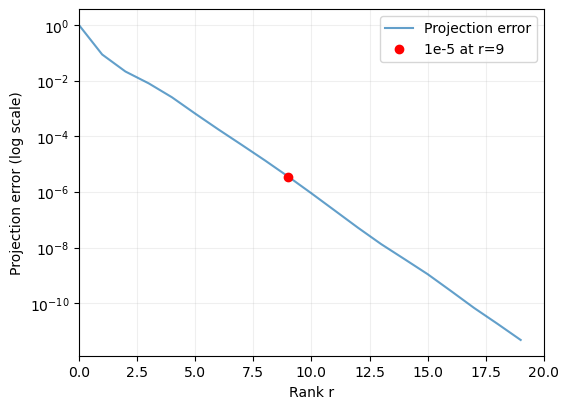

In [30]:
# plot the projection error
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot(proj_error_lst, label="Projection error", linestyle='-', alpha=0.7)

# plot the first idx when it is less than 1e-5
idx = np.where(np.array(proj_error_lst) < 1e-5)[0][0]
print("idx = ", idx)
ax.plot(idx, proj_error_lst[idx], 'ro', label=f"1e-5 at r={idx}")

ax.set_yscale('log')
ax.set_ylabel("Projection error (log scale)")
# set limit
ax.set_xlim([0, 20])
# ax.set_ylim([1e-13, 1e-3])
# show grid
ax.grid(True, alpha=0.2)
ax.set_xlabel("Rank r")
ax.legend()
plt.show()

# Define truncation order r

In [31]:
# Model parameters
# p = 2          # degree of polynomial embeddings
# r = np.min(idx_lst)           # number of basis vectors in Vr
# q = np.max(idx_lst) - r           # number of basis vectors in Vbar

r = 9
q = 6

tol = 1e-3      # tolerence for alternating minimization
gamma = 0.1       # regularization parameter
max_iter = 100  # maximum number of iterations

# Get the ROBs and save them for matlab OpInf routine

In [32]:
# Vr_lst = []
# Vbar_lst = []
# Shat_lst = []
# Xi_lst = []
# Poly_lst = []
# names = [f'{mu}' for mu in mus]

# for i in range(len(mus)):
#     # Procustes problem for each mu
#     S = X_all[i]
#     num_snapshots = S.shape[1]
#     sref = np.mean(S, axis=1)
#     Sref = np.array([sref,] * num_snapshots).T
    
    
#     Shat, energy, Xi, Vr, Vbar, Poly = alternating_minimization(S, Sref, num_snapshots, max_iter, 1e-3, gamma, r, q, p)
    
    
#     Gamma_MAM = Sref + (Vr @ Shat) + (Vbar @ Xi @ Poly)
#     print(f"\nReconstruction error: {relative_error(S, Gamma_MAM, Sref):.4%}")
    
#     Vr_lst.append(Vr)
#     Vbar_lst.append(Vbar)
#     Shat_lst.append(Shat)
#     Xi_lst.append(Xi)
#     Poly_lst.append(Poly)

In [33]:
Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
Poly_lst = []
names = [f'{mu}' for mu in mus]

for i in range(len(mus)):
    # Procustes problem for each mu
    S = X_all[i]
    num_snapshots = S.shape[1]
    sref = np.mean(S, axis=1)
    # use sref = 0
    # sref = 0
    Sref = np.array([sref,] * num_snapshots).T
    
    
    U, _, _ = np.linalg.svd((S-Sref), full_matrices=False)
    Vr = U[:, :r]
    Vbar = U[:, r:r+q]
    Shat = Vr.T @ (S-Sref)
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.identity((p - 1)*r))

    Gamma_MPOD = Sref + (Vr @ Shat) + (Vbar @ Xi @ Poly)
    print(f"\nReconstruction error: {relative_error(S, Gamma_MPOD, Sref):.4%}")
    
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(Shat)
    Xi_lst.append(Xi)
    Poly_lst.append(Poly)


Reconstruction error: 0.3665%

Reconstruction error: 0.3670%

Reconstruction error: 0.3742%

Reconstruction error: 0.3681%

Reconstruction error: 0.3627%

Reconstruction error: 0.3676%

Reconstruction error: 0.3544%

Reconstruction error: 0.3650%

Reconstruction error: 0.3479%

Reconstruction error: 0.3487%

Reconstruction error: 0.3605%

Reconstruction error: 0.3638%

Reconstruction error: 0.3695%

Reconstruction error: 0.3669%

Reconstruction error: 0.3685%

Reconstruction error: 0.3787%

Reconstruction error: 0.3885%

Reconstruction error: 0.3798%

Reconstruction error: 0.3747%

Reconstruction error: 0.3969%


In [50]:
# Save the data
ROBsNL_path = Path(datapath) / 'ROBsNL'

Vr_arr = np.array(Vr_lst)
Vbar_arr = np.array(Vbar_lst)
Shat_arr = np.array(Shat_lst)
Xi_arr = np.array(Xi_lst)
Poly_arr = np.array(Poly_lst)

Vr_arr = np.transpose(Vr_arr, (1, 2, 0))
Vbar_arr = np.transpose(Vbar_arr, (1, 2, 0))
Shat_arr = np.transpose(Shat_arr, (1, 2, 0))
Xi_arr = np.transpose(Xi_arr, (1, 2, 0))
Poly_arr = np.transpose(Poly_arr, (1, 2, 0))

if perturbations:
    savemat(f'{ROBsNL_path}/Vr_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb_{uid}.mat', {'Vr_all': Vr_arr})
    savemat(f'{ROBsNL_path}/Vbar_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb_{uid}.mat', {'Vbar_all': Vbar_arr})
    savemat(f'{ROBsNL_path}/Shat_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb_{uid}.mat', {'Shat_all': Shat_arr})
    savemat(f'{ROBsNL_path}/Xi_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb_{uid}.mat', {'Xi_all': Xi_arr})
    savemat(f'{ROBsNL_path}/Poly_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb_{uid}.mat', {'Poly_all': Poly_arr})
else:
    savemat(f'{ROBsNL_path}/Vr_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Vr_all': Vr_arr})
    savemat(f'{ROBsNL_path}/Vbar_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Vbar_all': Vbar_arr})
    savemat(f'{ROBsNL_path}/Shat_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Shat_all': Shat_arr})
    savemat(f'{ROBsNL_path}/Xi_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Xi_all': Xi_arr})
    savemat(f'{ROBsNL_path}/Poly_all_mu_{mu_start}_{mu_step}_{mu_end}.mat', {'Poly_all': Poly_arr})

# Matlab routine for OpInf

In [1]:
# params.modelform = 'LQI';           % model is linear-quadratic with input term
# params.modeltime = 'continuous';    % learn time-continuous model
# params.dt        = dt;              % timestep to compute state time deriv
# params.ddt_order = '1ex';           % explicit 1st order timestep scheme

# % Inputs:
# %   - params: parameters for the operator inference, including:
# %       - modelform: model form of the operator
# %       - modeltime: model time of the operator
# %       - dt: timestep to compute state time derivative
# %       - ddt_order: explicit 1st order timestep scheme
# %   - mus: parameter values
# %   - r: POD basis order
# %   - X_all: state data
# %   - R_all: RHS data (residual)
# %   - U_all: input data
# %   - Vr_all: truncated POD basis


# update config file with truncation order r
config['robparams'] = {
    "r": int(r)
}

config_path = Path(srcpath) / 'configs'/ f'config_nominalmu_{int(nominal_mu*1/scaling)}_perturb_{uid}.json'
with open(config_path, 'w') as f:
    json.dump(config, f)


matlab_opinf_cmd = (
    f"matlab -batch \"addpath('/home/jy384/projects/UnimodalSROB/examples/burgers/'); "
    f"run_burgersOpInf_NL('{config_path}'); exit;\""
)

# Use subprocess to call MATLAB
subprocess.run(matlab_opinf_cmd, shell=True, check=True)

NameError: name 'r' is not defined

In [56]:
# Read s_ref_all.mat and s_rec_all.mat
reconstructedState_path = Path(datapath) / 'reconstructedState'
referenceState_path = Path(datapath) / 'referenceState'

if config['perturbations']:
    s_ref_all = loadmat(f'{referenceState_path}/s_ref_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb_{uid}.mat')['s_ref_all']
    s_rec_all = loadmat(f'{reconstructedState_path}/s_rec_all_nominalmu_{int(nominal_mu*1/scaling)}_perturb_{uid}.mat')['s_rec_all']
else:
    s_ref_all = loadmat(f'{referenceState_path}/s_ref_all_mu_{mu_start}_{mu_step}_{mu_end}.mat')['s_ref_all']
    s_rec_all = loadmat(f'{reconstructedState_path}/s_rec_all_mu_{mu_start}_{mu_step}_{mu_end}.mat')['s_rec_all']

# extract the tensors from the cell arrays
s_ref_all = np.array([s_ref_all[i][0] for i in range(s_ref_all.shape[0])])
# s_ref_all = [s_ref_all[i][0] for i in range(s_ref_all.shape[0])]
s_rec_all = np.array([s_rec_all[i][0] for i in range(s_rec_all.shape[0])])
# s_rec_all = [s_rec_all[i][0] for i in range(s_rec_all.shape[0])]

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


/tmp/ipykernel_2623801/3340207870.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


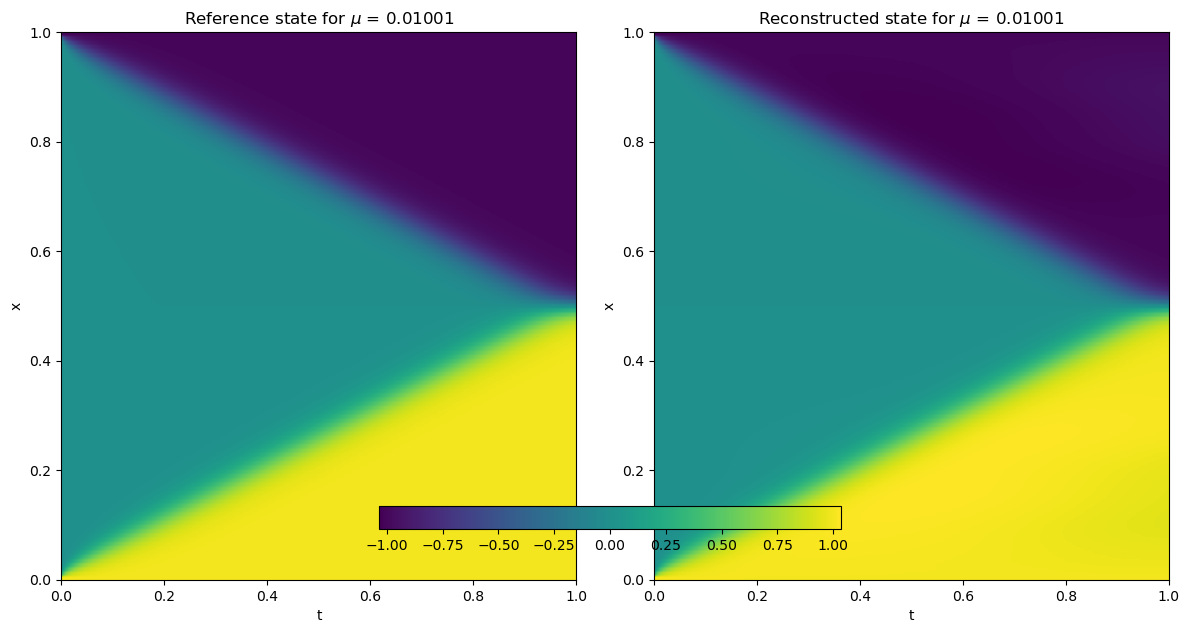

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


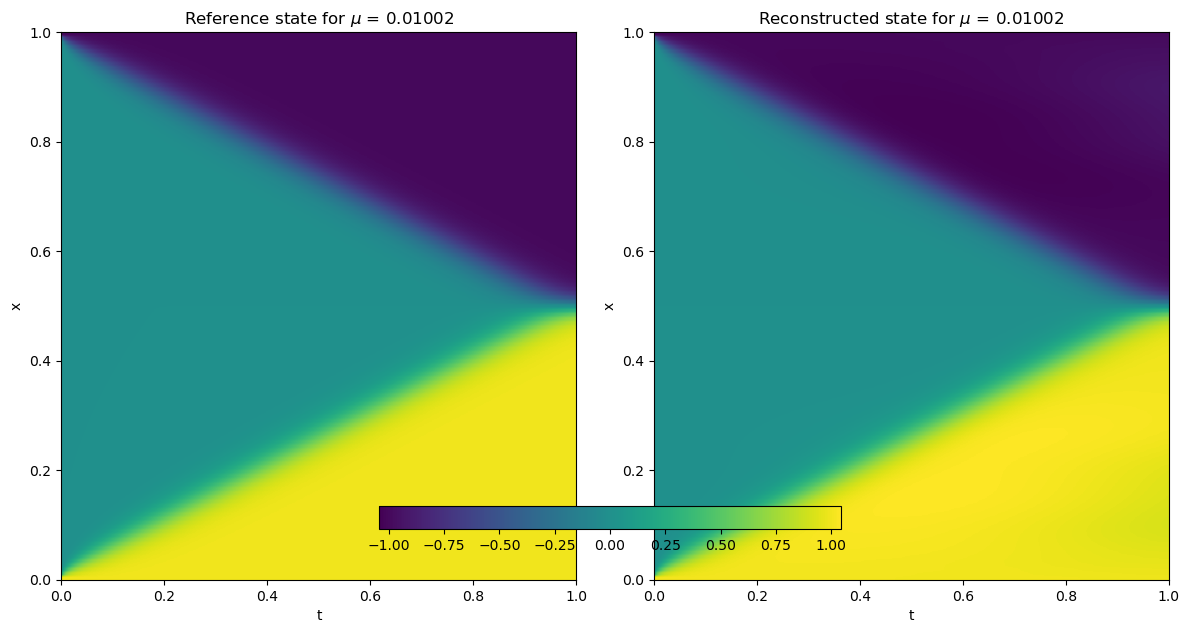

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


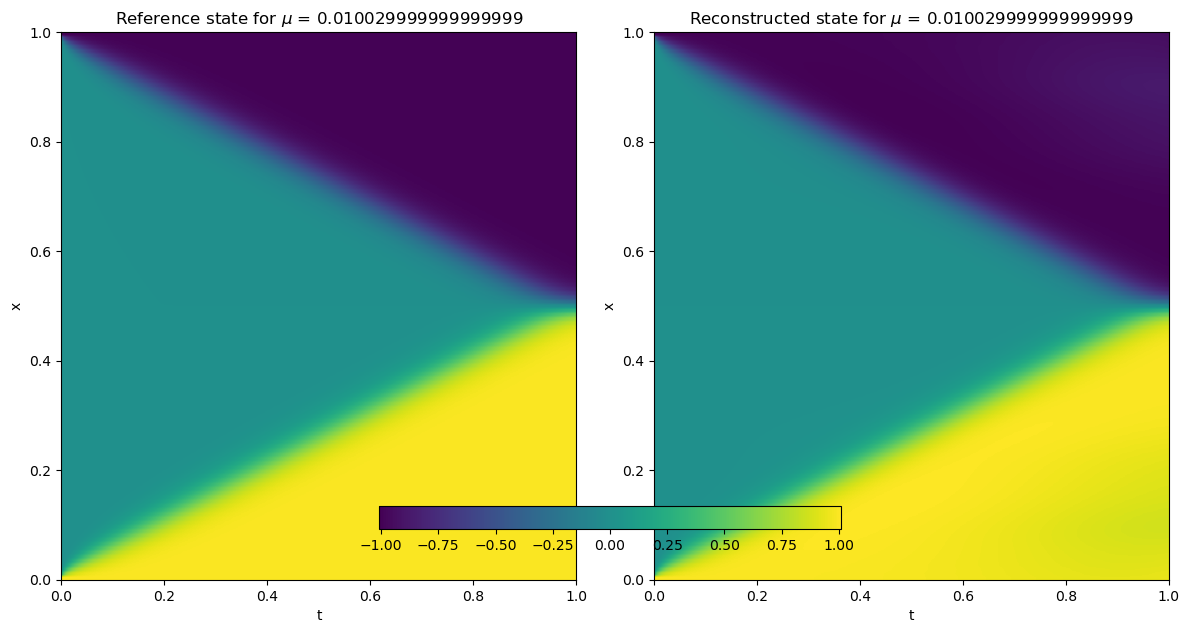

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


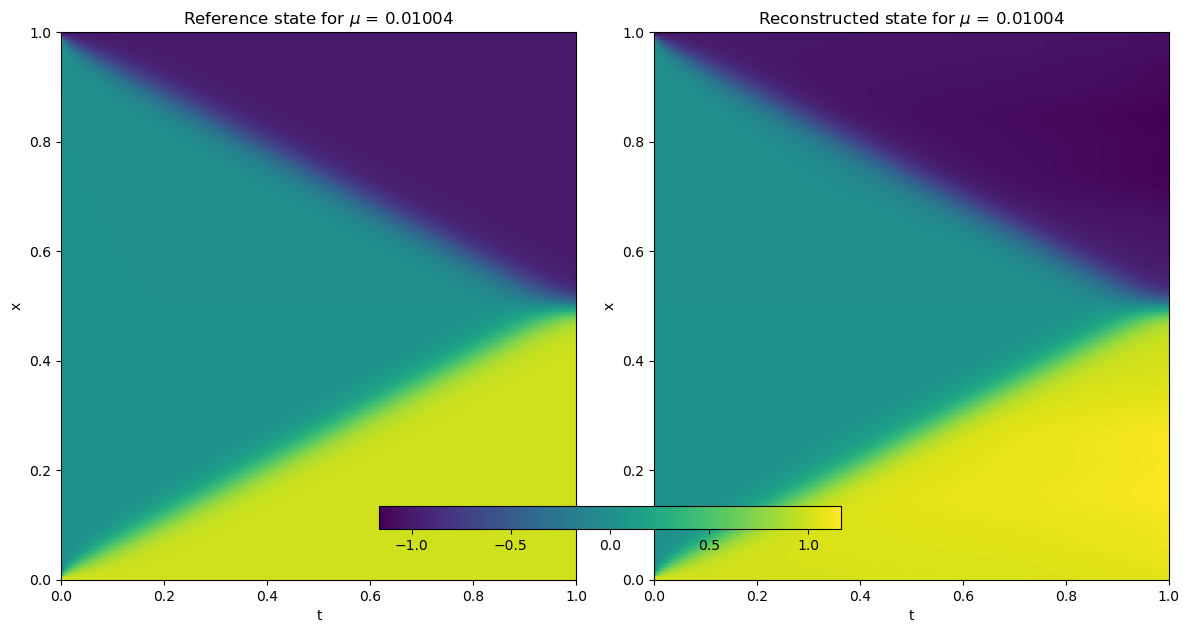

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


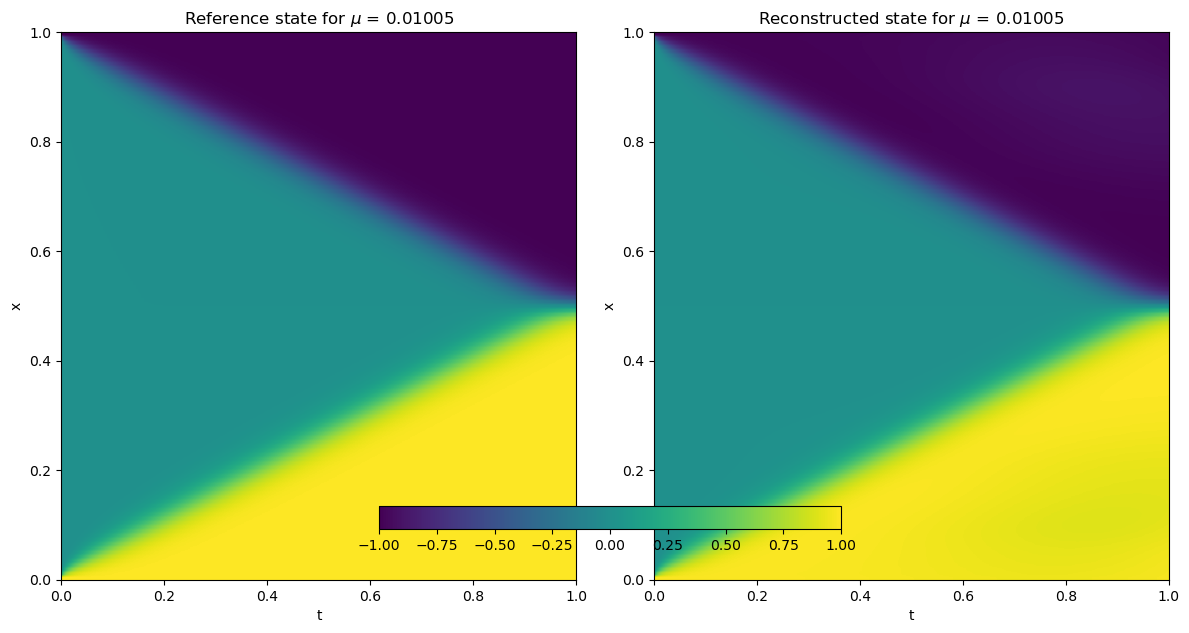

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


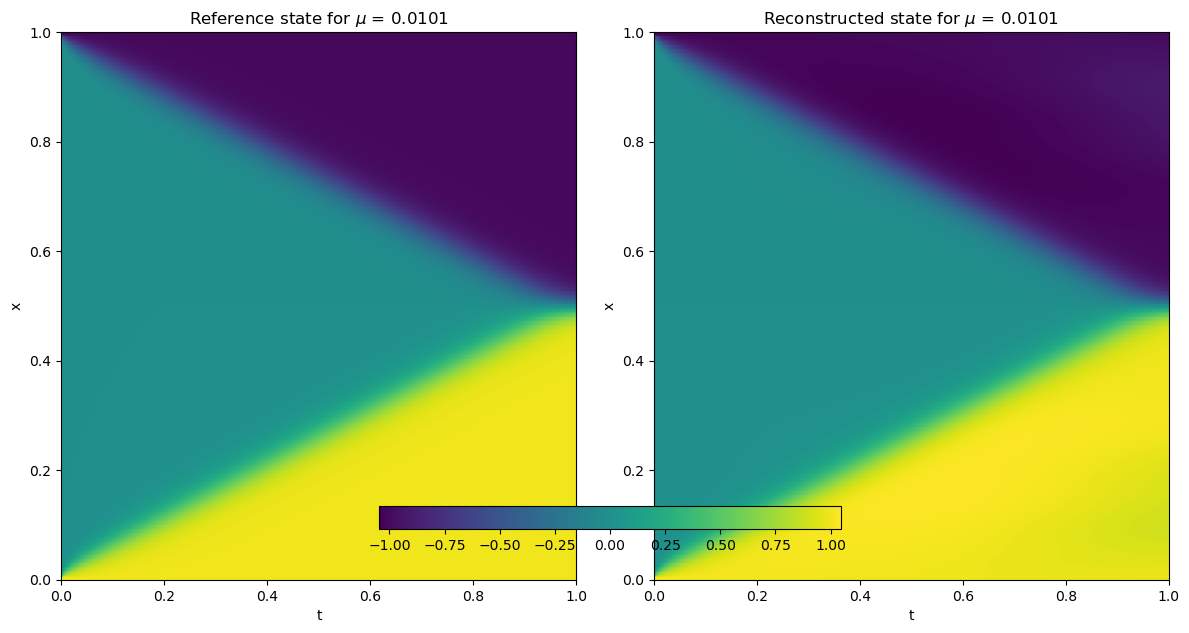

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


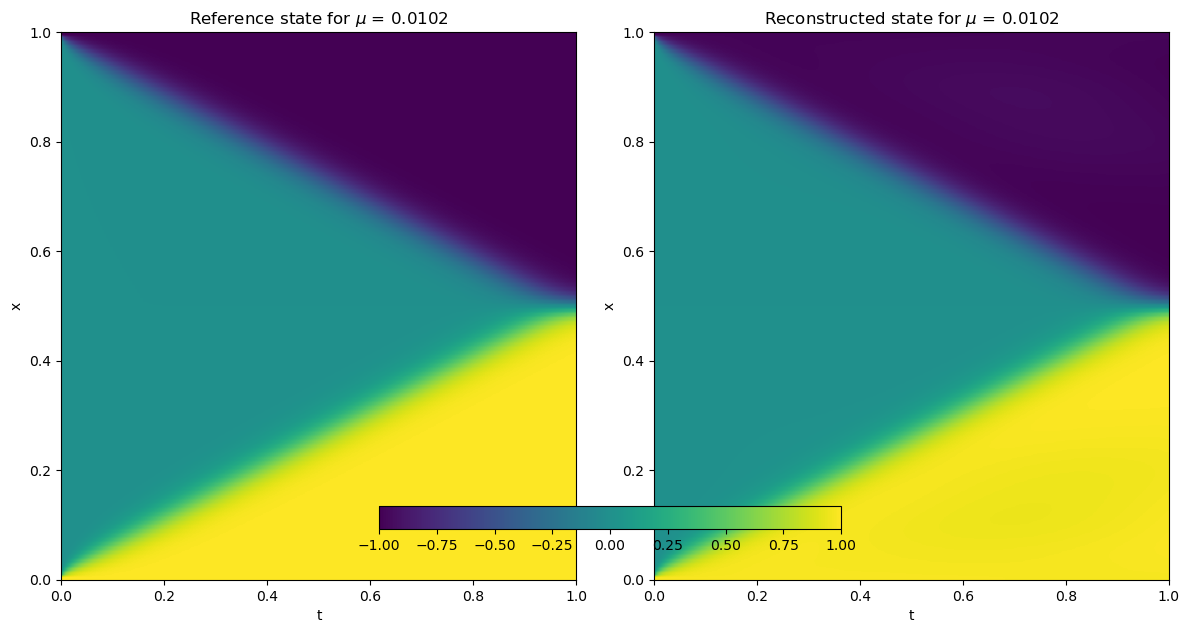

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


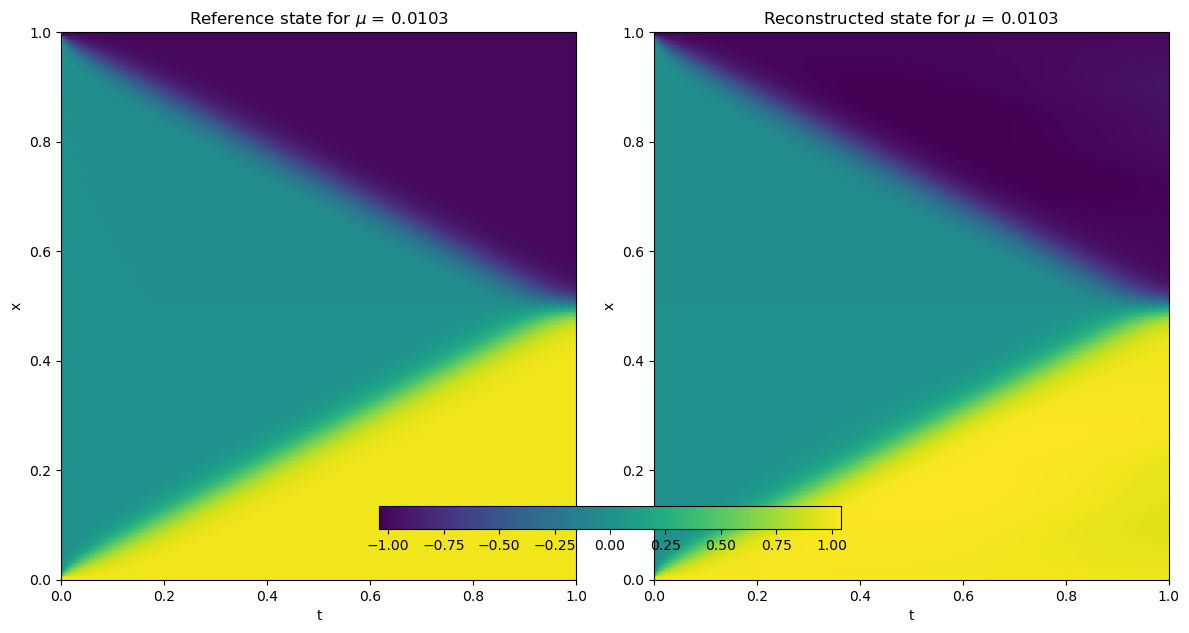

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


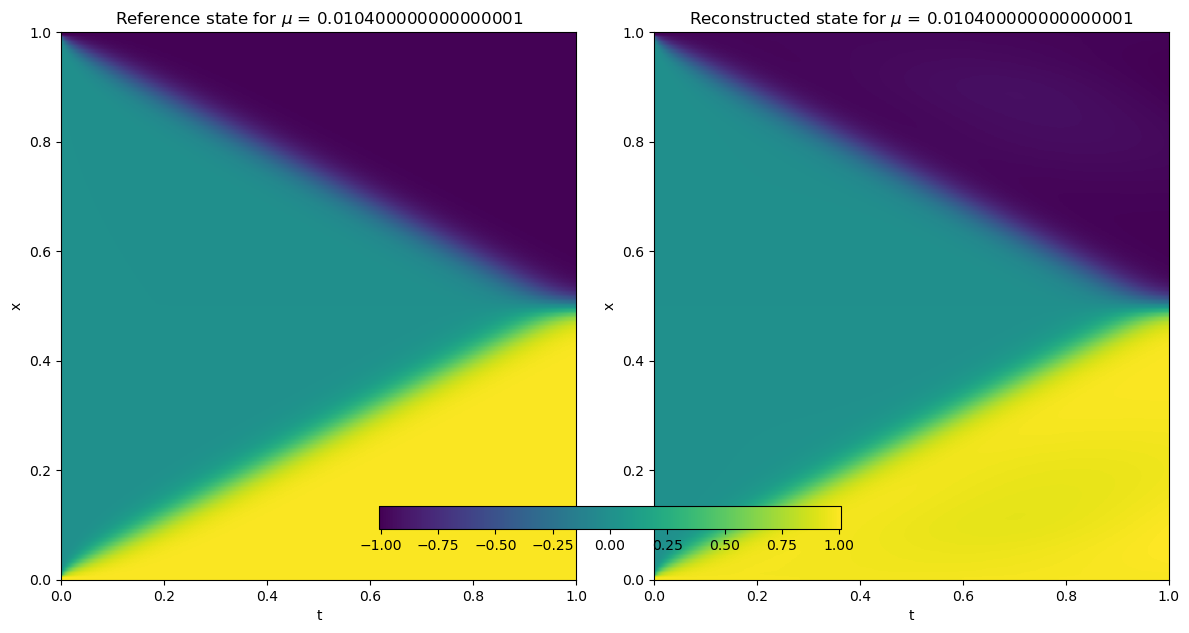

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


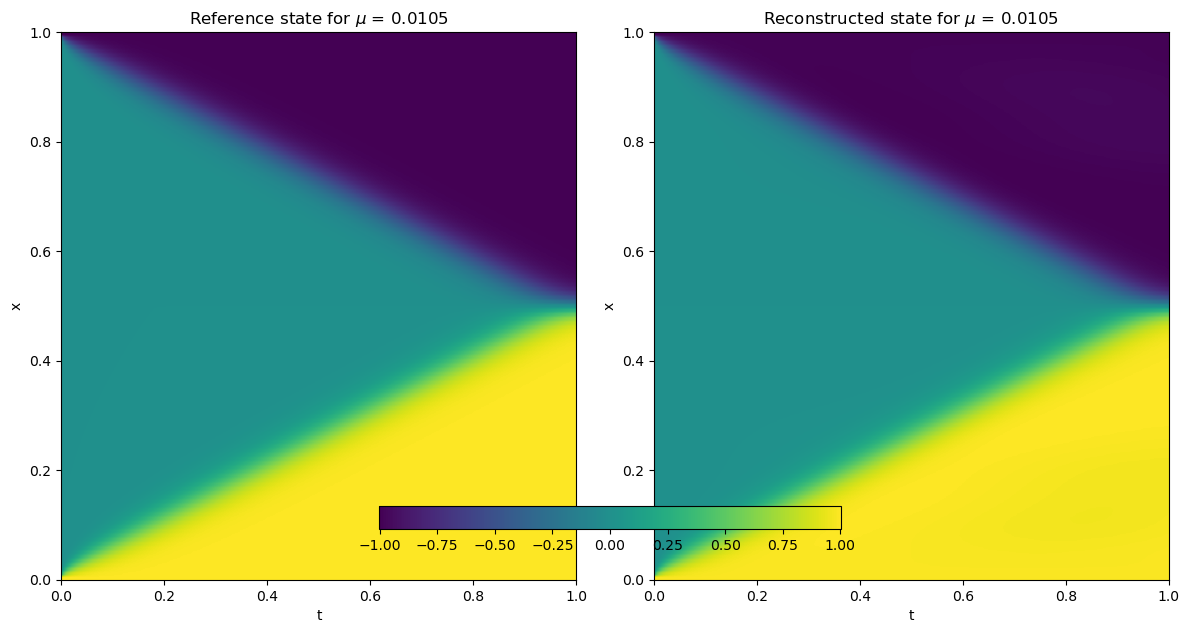

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


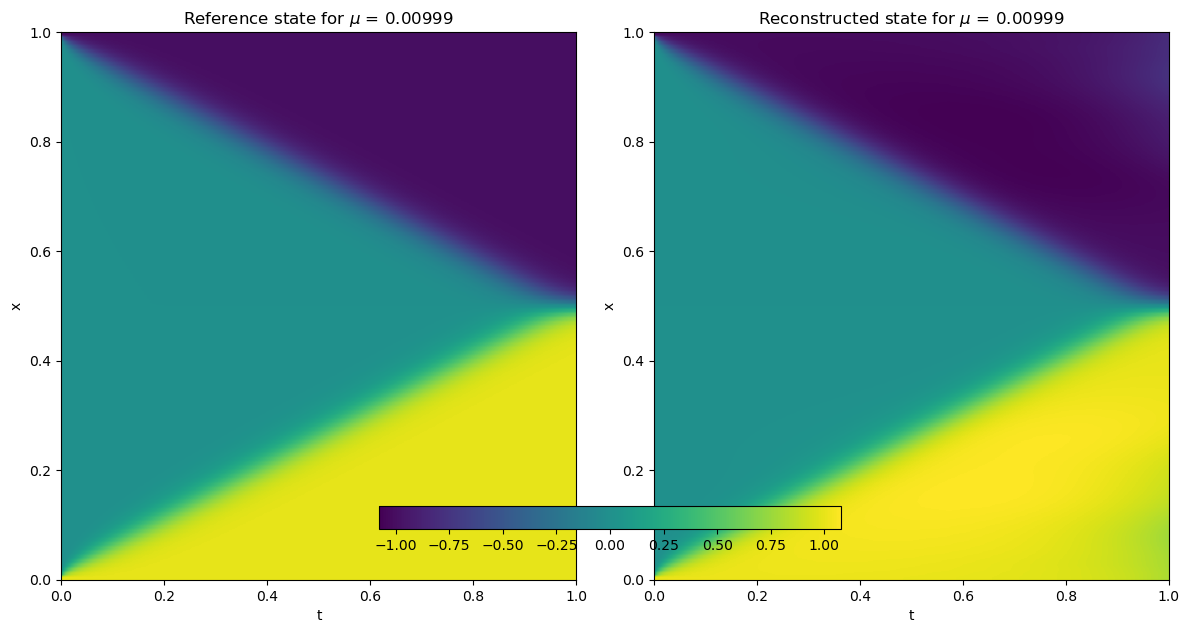

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


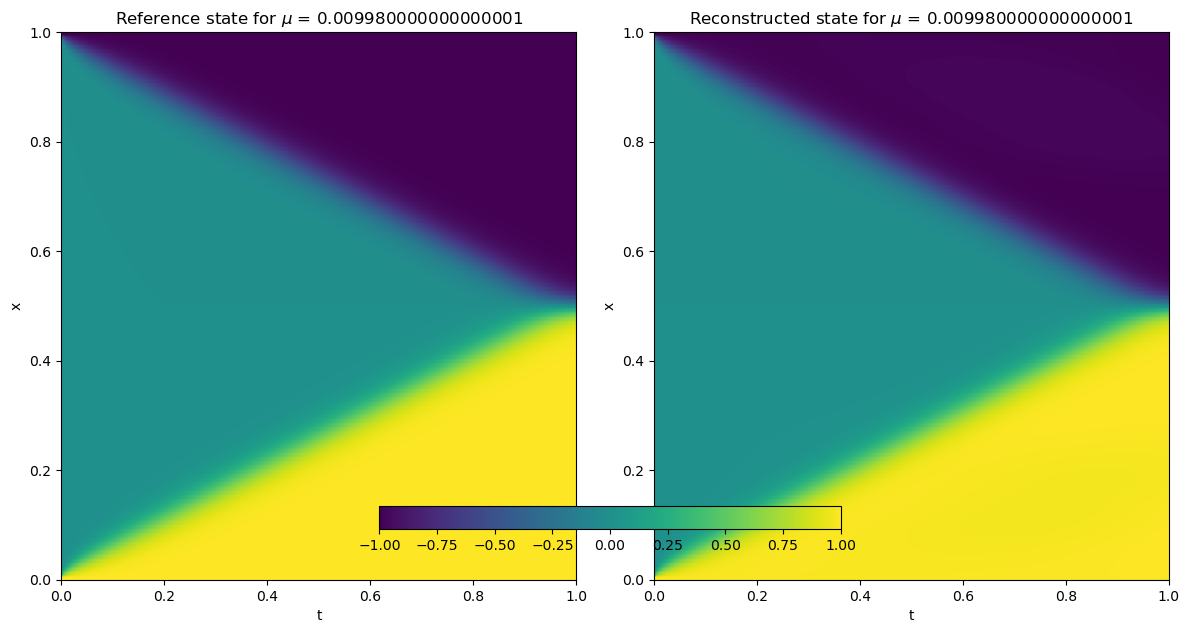

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


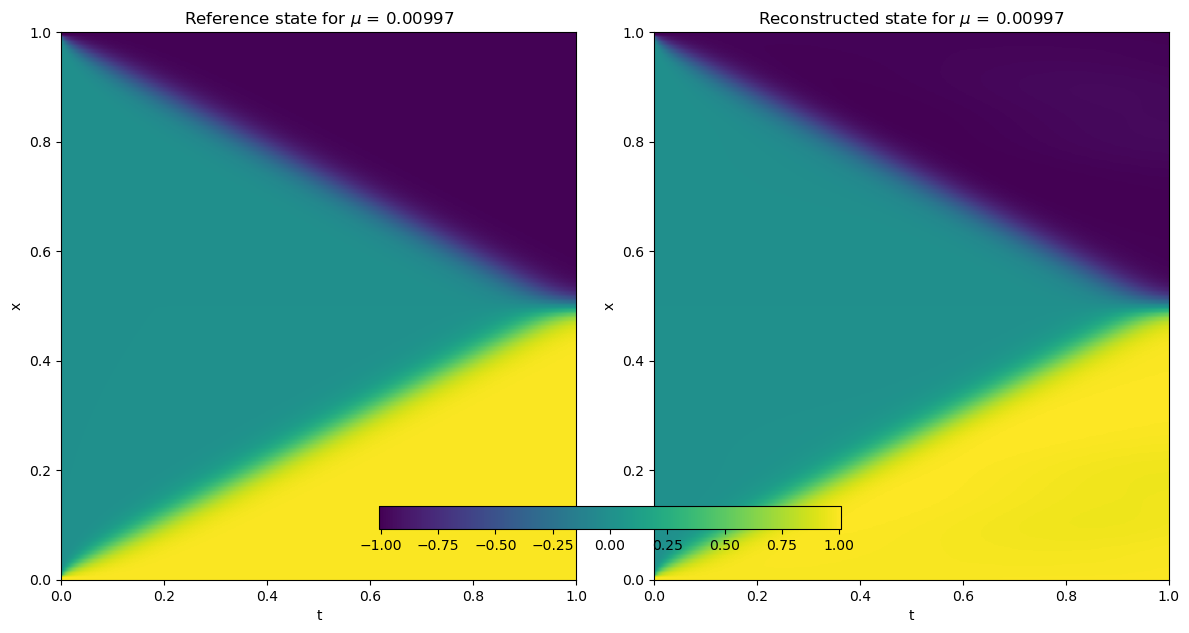

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


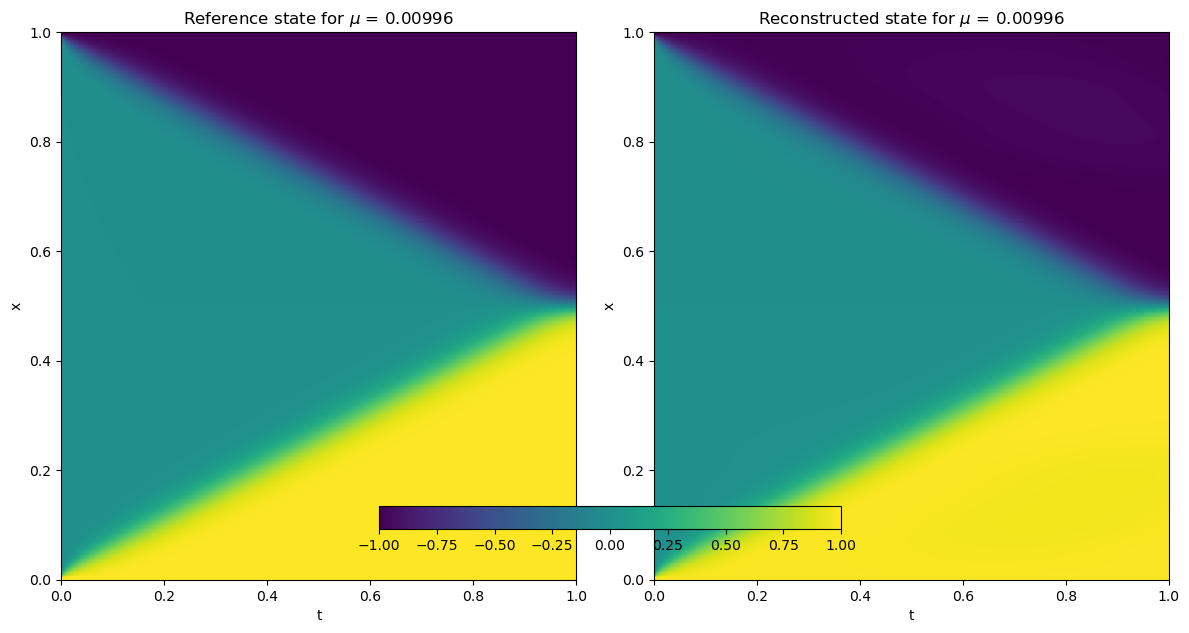

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


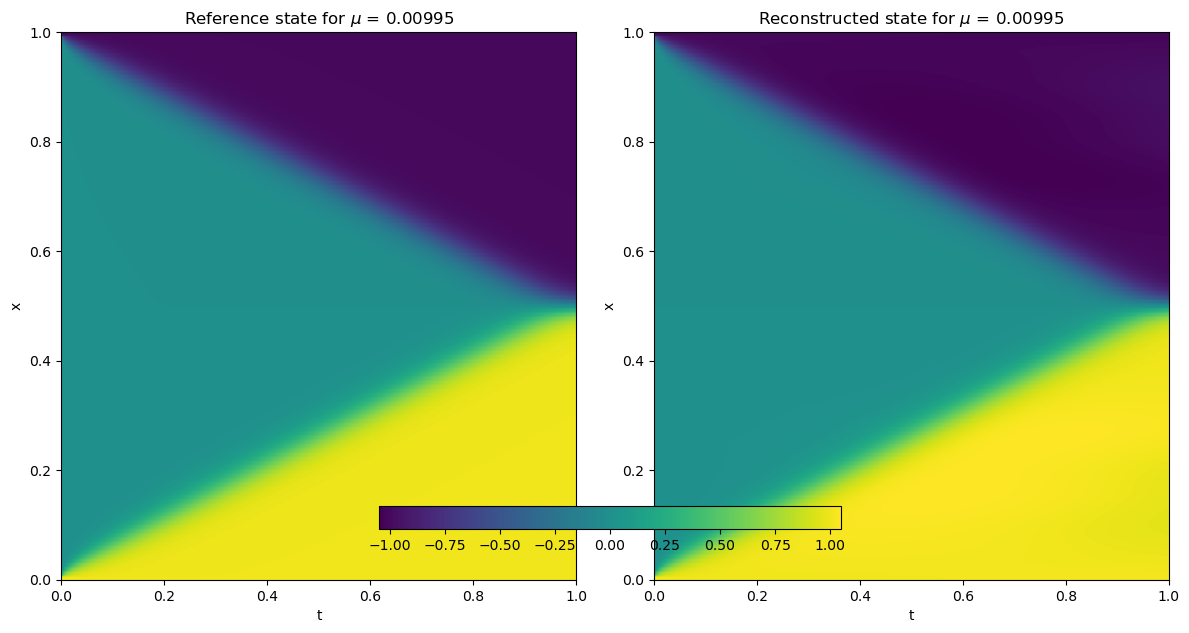

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


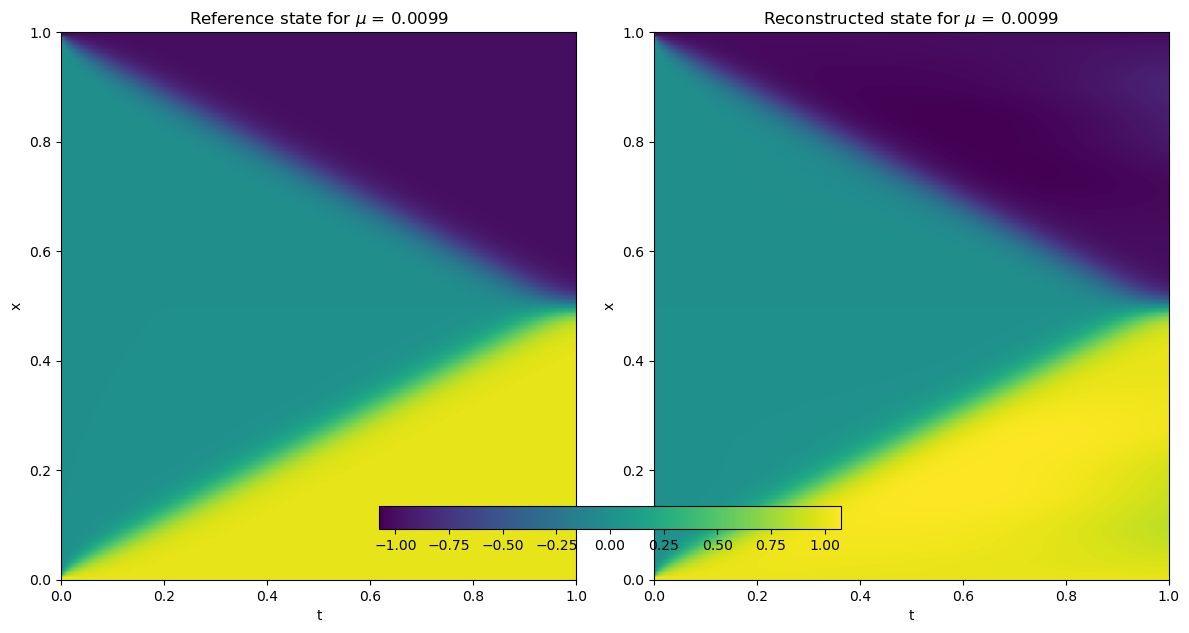

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


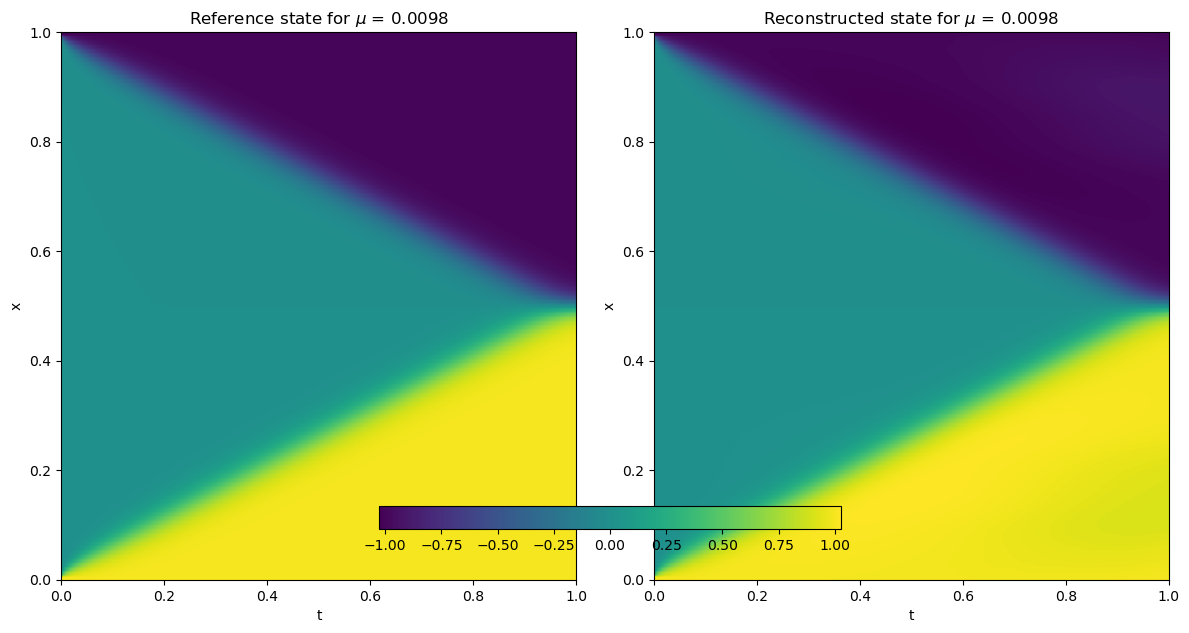

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


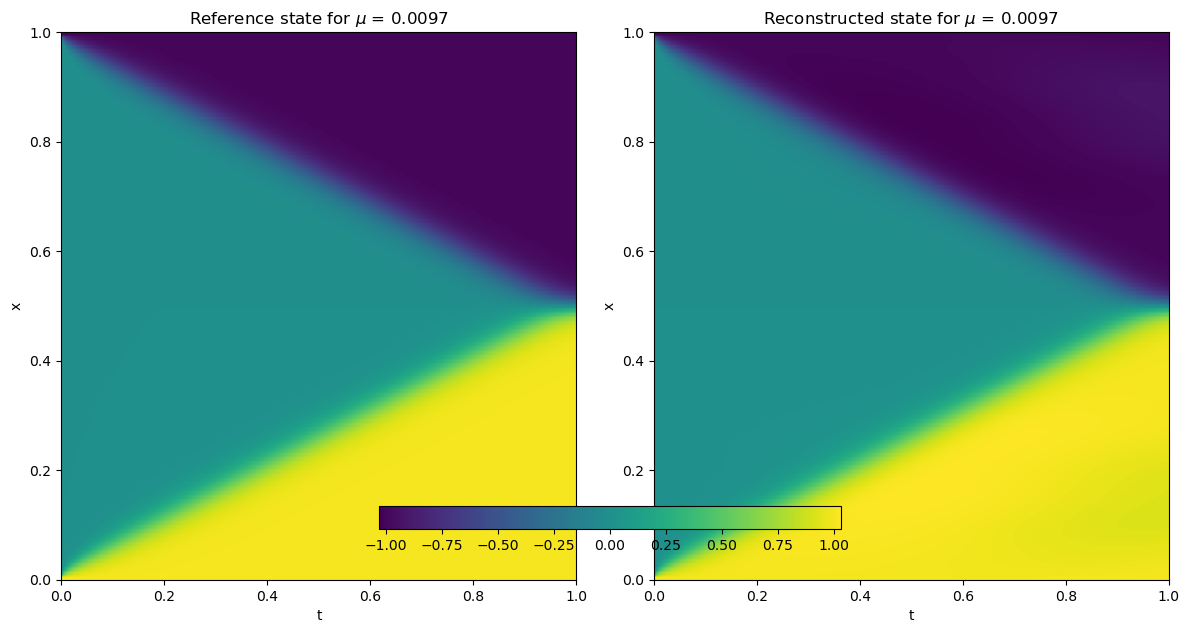

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


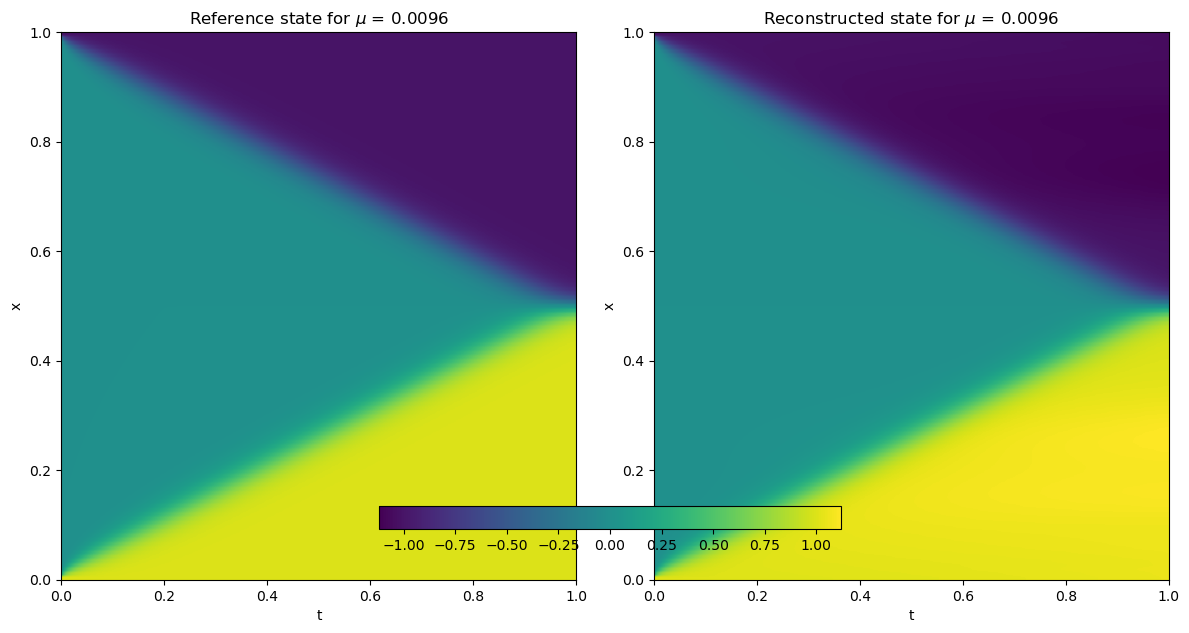

X =  (129, 10001)
Y =  (129, 10001)
s_ref_all[i] =  (129, 10001)


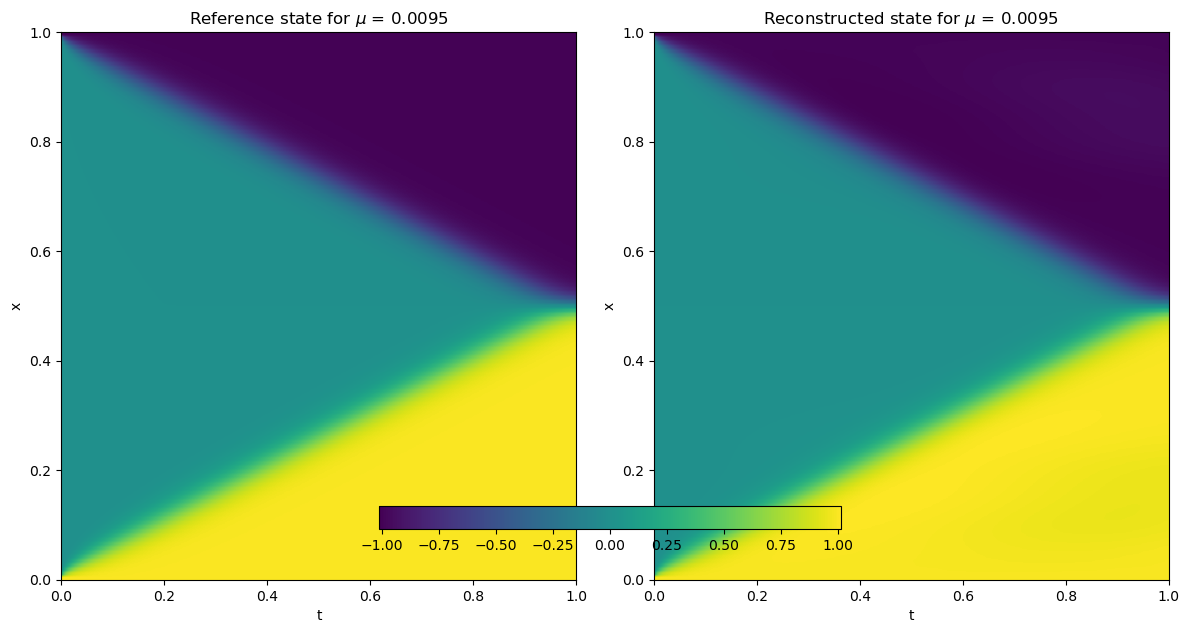

In [57]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(len(mus)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    X, Y = np.meshgrid(np.linspace(0.0, T_end, int(K+1)), np.linspace(0.0, 1.0, N))
    print("X = ", X.shape)
    print("Y = ", Y.shape)
    print("s_ref_all[i] = ", s_ref_all[i].shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    c1 = axs[0].imshow(s_ref_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    # plot the trajectory of x coordinate across time, x-axis is time, y-axis is x
    # axs[0].scatter(np.linspace(0.0, T_end, U_all.shape[0]), U_all[:, i], color='red', s=1)
    # fig.colorbar(c)
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'Reference state for $\mu$ = {mus[i]}')
    
    c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    
    # fig.colorbar(c)
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Reconstructed state for $\mu$ = {mus[i]}')  
    
    # use same colorbar for both plots, the range is determined by the maximum and minimum values of the two plots
    vmin = np.min([np.min(s_ref_all[i]), np.min(s_rec_all[i])])
    vmax = np.max([np.max(s_ref_all[i]), np.max(s_rec_all[i])])
    c1.set_clim(vmin=vmin, vmax=vmax)
    c2.set_clim(vmin=vmin, vmax=vmax)
    
    fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.tight_layout()
    
    
    plt.show()

In [58]:
# get standard deviation of the reconstructed state
stds = np.std(s_rec_all, axis=0)
print("stds = ", stds.shape)

# load nominal state by finding the file with name containing 'mu_0.01' using glob
nominalState_path = list(Path(datapath).rglob(f's_ref_all_mu_{nominal_mu}_*'))
nominalState = loadmat(nominalState_path[0])['s_ref_all']

# only get the first element of the cell array
nominalState = nominalState[0][0]
print("nominalState = ", nominalState.shape)

stds =  (129, 10001)
nominalState =  (129, 10001)


X =  (129, 10001)
Y =  (129, 10001)
nominalState =  (129, 10001)


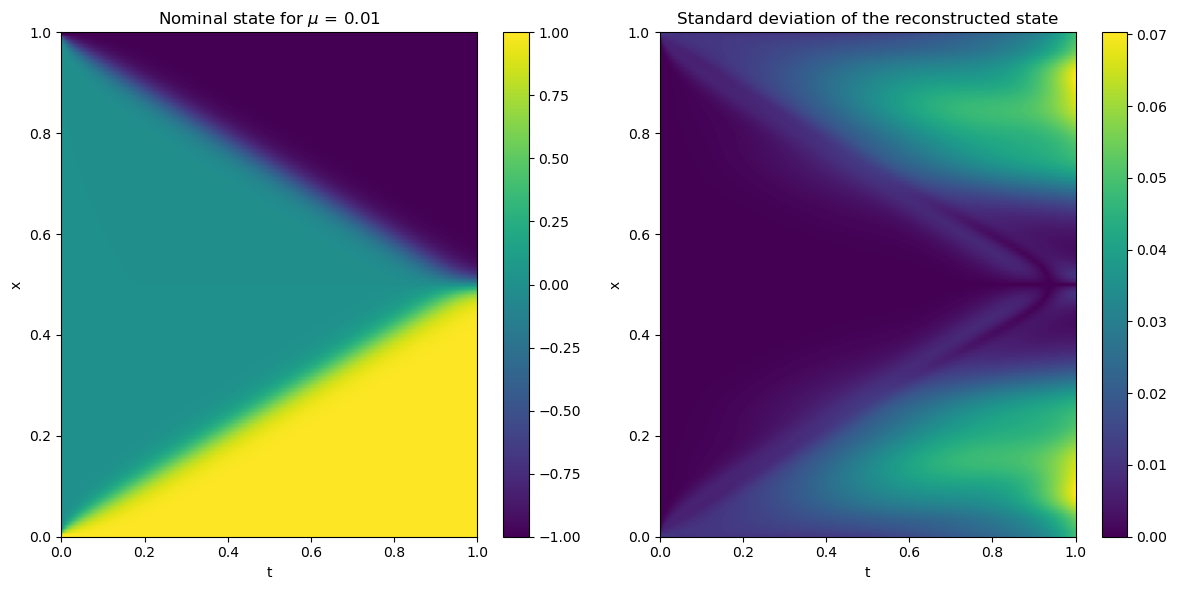

In [59]:
# plot the standard deviation of the reconstructed state on the right side of the nominal state
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
X, Y = np.meshgrid(np.linspace(0.0, T_end, int(K+1)), np.linspace(0.0, 1.0, N))
print("X = ", X.shape)
print("Y = ", Y.shape)
print("nominalState = ", nominalState.shape)
# s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
c1 = axs[0].imshow(nominalState.reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
# color bar for the nominal state plot by getting the minimum and maximum values of the nominal state
vmin = np.min(nominalState)
vmax = np.max(nominalState)
c1.set_clim(vmin=vmin, vmax=vmax)
fig.colorbar(c1)

axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_title(f'Nominal state for $\mu$ = {nominal_mu}')

c2 = axs[1].imshow(stds.reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')

fig.colorbar(c2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('x')
axs[1].set_title(f'Standard deviation of the reconstructed state')

plt.tight_layout()
plt.show()


In [61]:
s_ref_all.shape

(20, 129, 10001)

In [62]:
# get the relative error of the reconstructed state except the initial condition
for i in range(len(mus)):
    rel_err = np.linalg.norm(s_rec_all[i][:, 1:] - s_ref_all[i][:, 1:]) / np.linalg.norm(s_ref_all[i][:, 1:])
    print("Relative error for mu = ", mus[i], " is ", rel_err)

Relative error for mu =  0.01001  is  0.024574262060529133
Relative error for mu =  0.01002  is  0.03035495930689492
Relative error for mu =  0.010029999999999999  is  0.04407193208760041
Relative error for mu =  0.01004  is  0.07201653380053012
Relative error for mu =  0.01005  is  0.044362538644124996
Relative error for mu =  0.0101  is  0.035253277251419066
Relative error for mu =  0.0102  is  0.02939047414324875
Relative error for mu =  0.0103  is  0.026758439045996056
Relative error for mu =  0.010400000000000001  is  0.034275460029135056
Relative error for mu =  0.0105  is  0.017777218310826674
Relative error for mu =  0.00999  is  0.0576483887241378
Relative error for mu =  0.009980000000000001  is  0.0171712242690291
Relative error for mu =  0.00997  is  0.019080765868649832
Relative error for mu =  0.00996  is  0.022525431727605447
Relative error for mu =  0.00995  is  0.03086432329898704
Relative error for mu =  0.0099  is  0.04821989985452898
Relative error for mu =  0.0098 

stds =  (129, 10001)
X =  (129, 10001)
Y =  (129, 10001)
nominalState =  (129, 10001)


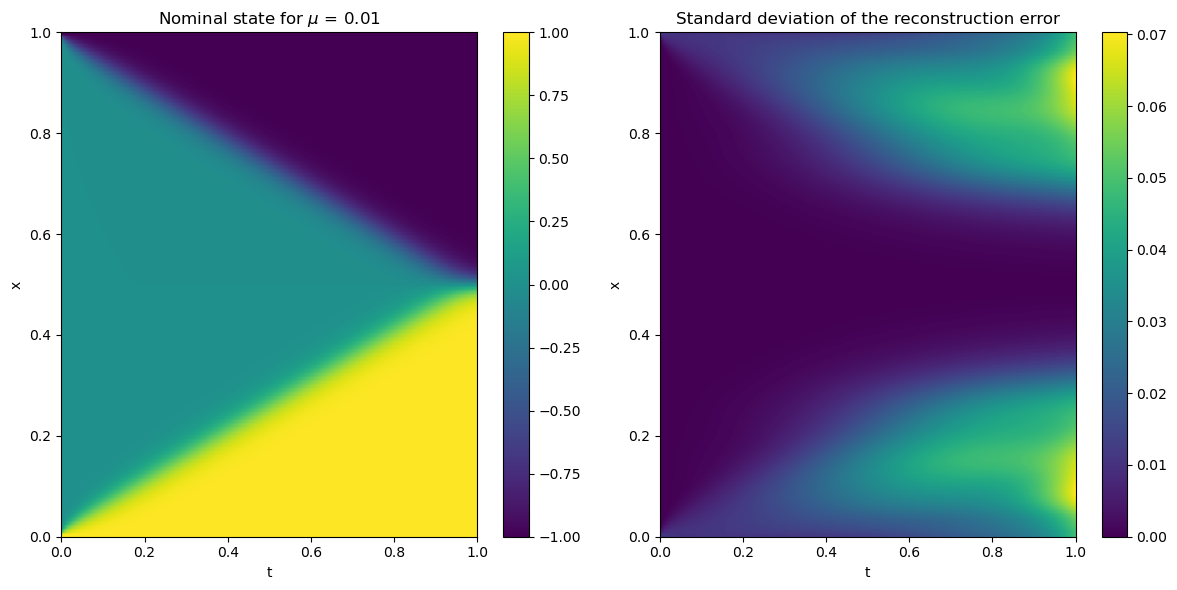

In [60]:
# plot the standard deviation of the reconstruction error
stds = np.std(s_rec_all - s_ref_all, axis=0)
print("stds = ", stds.shape)

# plot the standard deviation of the reconstructed state on the right side of the nominal state
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
X, Y = np.meshgrid(np.linspace(0.0, T_end, int(K+1)), np.linspace(0.0, 1.0, N))
print("X = ", X.shape)
print("Y = ", Y.shape)
print("nominalState = ", nominalState.shape)
# s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
c1 = axs[0].imshow(nominalState.reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
# color bar for the nominal state plot by getting the minimum and maximum values of the nominal state
vmin = np.min(nominalState)
vmax = np.max(nominalState)
c1.set_clim(vmin=vmin, vmax=vmax)
fig.colorbar(c1)

axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
axs[0].set_title(f'Nominal state for $\mu$ = {nominal_mu}')

c2 = axs[1].imshow(stds.reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')

fig.colorbar(c2)
axs[1].set_xlabel('t')
axs[1].set_ylabel('x')
axs[1].set_title(f'Standard deviation of the reconstruction error')

plt.tight_layout()
plt.show()